# Import packages

In [28]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import cross_validate, cross_val_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Import data

In [29]:
X_train = pd.read_csv('../data/X_train_trans.csv', index_col=0)
X_test = pd.read_csv('../data/X_test_trans.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

pickle_in = open('../data/y_test.pickle', 'rb')
y_test = pickle.load(pickle_in)

# Create LogisticRegression model and conduct GridSearch

In [30]:
logreg = LogisticRegressionCV(solver = 'lbfgs', random_state=3, n_jobs=-1)
logreg.fit(X_train, y_train)

y_predv = logreg.predict(X_train)

In [31]:
params = {'solver': ['lbfgs'],
          'penalty': ['l1', 'l2'],
          'Cs': [.01, .1, 1, 50, 100, 500, 1000, 10000]
}

In [32]:
gscv = GridSearchCV(logreg, params, n_jobs = -1, verbose = 1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1.0,
                                            l1_ratios=None, max_iter=100,
                                            multi_class='auto', n_jobs=-1,
                                            penalty='l2', random_state=3,
                                            refit=True, scoring=None,
                                            solver='lbfgs', tol=0.0001,
                                            verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'Cs': [0.01, 0.1, 1, 50, 100, 500, 1000, 10000],
                         'penalty': ['l1', 'l2'], 'solver': ['lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [33]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_Cs', 'param_penalty', 'param_solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [34]:
results = pd.DataFrame(gscv.cv_results_)
results[['rank_test_score', 'mean_test_score', 'param_Cs',
         'param_penalty']].\
            sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,param_Cs,param_penalty
7,1,0.863698,50,l2
9,2,0.862413,100,l2
11,2,0.862413,500,l2
13,2,0.862413,1000,l2
15,2,0.862413,10000,l2


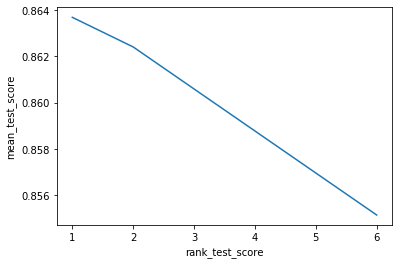

In [35]:
sns.lineplot(x = results.rank_test_score, y = results.mean_test_score)

In [36]:
cs = gscv.cv_results_['param_Cs'][gscv.best_index_]
penalty = gscv.cv_results_['param_penalty'][gscv.best_index_]
solver = gscv.cv_results_['param_solver'][gscv.best_index_]

In [37]:
print('- Cs: {}\n- penalty: {}\n- solver: {}'\
      .format(c, penalty, solver))

- Cs: 50
- penalty: l2
- solver: lbfgs


#  Fit model with best parameters identified

In [38]:
logreg_best = LogisticRegressionCV(solver = 'lbfgs', Cs=50, penalty='l2', random_state=3, n_jobs=-1)
logreg_best.fit(X_test, y_test)

LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=3, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [39]:
y_pred = logreg_best.predict(X_test)
y_prob = logreg_best.predict_proba(X_test)

In [40]:
print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_test, y_pred), 
                accuracy_score(y_test, y_pred), 
                recall_score(y_test, y_pred), 
                f1_score(y_test, y_pred)))

Precision: 0.6923076923076923
Accuracy: 0.86
Recall: 0.06206896551724138
F1: 0.11392405063291139


# Plot ROC curve

In [41]:
# Create vanilla model for comparison
log_van = LogisticRegressionCV(random_state=3, n_jobs-1)

SyntaxError: positional argument follows keyword argument (<ipython-input-41-3354998e0391>, line 2)

In [ ]:
log_van.fit(X_test, y_test)
y_pred_van = log_van.predict(X_test)
y_prob_van = log_van.predict_proba(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
fpr_v, tpr_v, thresholds_v = roc_curve(y_test, y_prob_van[:,1])

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth =5 , label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr_v, tpr_v, label = 'Vanilla')
plot_roc_curve(fpr, tpr, label = 'Tuned Model')
plt.legend()
plt.show()

In [42]:
logreg_best_tr = LogisticRegressionCV(solver = 'lbfgs', Cs=50, penalty='l2', random_state=3, n_jobs=-1)
logreg_best_tr.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=3, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [44]:
y_pred_tr = logreg_best_tr.predict(X_train)

In [45]:
print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_train, y_pred_tr), 
                accuracy_score(y_train, y_pred_tr), 
                recall_score(y_train, y_pred_tr), 
                f1_score(y_train, y_pred_tr)))

Precision: 0.6134453781512605
Accuracy: 0.866695242177454
Recall: 0.21597633136094674
F1: 0.31947483588621445
